## TME IAR - Deep Learning for Image Classification

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
# from torch.autograd import Variable
# from PIL import ImageFile
from dataloader import *
from plotdata import *
# import os
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.ndimage.filters import gaussian_filter1d
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix
import seaborn as sn
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.01
momentum = 0.5
batch_size_train = 40
batch_size_test = 500

In [3]:
# evaluation on a batch of test data:
def evaluate(model, data):
    batch_enum = enumerate(data.loader_test)
    batch_idx, (testdata, testtargets) = next(batch_enum)
    model = model.eval()
    oupt = torch.argmax(model(testdata), dim=1)
    t = torch.sum(oupt == testtargets)
    result = t * 100.0 / len(testtargets)
    model = model.train()
    print(f"{t} correct on {len(testtargets)} ({result.item()} %)")
    return result.item()


# iteratively train on batches for one epoch:
def train_epoch(model, optimizer, data, loss_record):
    batch_enum = enumerate(data.loader_train)
    i_count = 0
    iterations = data.num_train_samples // data.batch_size_train
    for batch_idx, (dt, targets) in batch_enum:
        i_count = i_count+1
        outputs = model(dt)
        loss = F.cross_entropy(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not i_count % 30:
            print(f"    step {i_count} / {iterations}")
            loss_record.append(loss.item())
        if i_count == iterations:
            break


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(((((75-2)//2-2)//2)**2)*64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
        
        # print('size:', ((((75-2)//2-2)//2)**2)*64) # 18496

    def forward(self, x):
        x = F.relu(self.conv1(x.view(-1, 3, 75, 75)))
        x = self.dropout1(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = self.dropout2(F.max_pool2d(x, 2))
        x = torch.flatten(x, 1)
        x = self.dropout3(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [4]:
data = loadImgs(batch_size_train=batch_size_train, batch_size_test=batch_size_test)

net = Net().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

net.load_state_dict(torch.load('./data/model_TP.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
def eval_net(its = 1):
    acc = 0

    print('Doing', its, 'evaluations:')
    for i in range(its):
        eval = evaluate(net, data)
        print(i+1, ') ', eval)
        acc = acc + eval

    med = acc/its
    print('Final medium evaluation:', med)

eval_net(5)

Doing 5 evaluations:
419 correct on 500 (83.80000305175781 %)
1 )  83.80000305175781
423 correct on 500 (84.5999984741211 %)
2 )  84.5999984741211
415 correct on 500 (83.0 %)
3 )  83.0
410 correct on 500 (82.0 %)
4 )  82.0
406 correct on 500 (81.19999694824219 %)
5 )  81.19999694824219
Final medium evaluation: 82.91999969482421


In [7]:
def train_net(loss_record, train_num_epochs = 1): 
    for j in range(train_num_epochs):
        print(f"epoch {j} / {train_num_epochs}")
        train_epoch(net, optimizer, data, loss_record)
        evaluate(net, data)
        torch.save(net.state_dict(), './data/model_TP.pt')

    indices = np.random.choice(range(data.num_test_samples), 20)
    plotdata(data, indices, net, original=True)

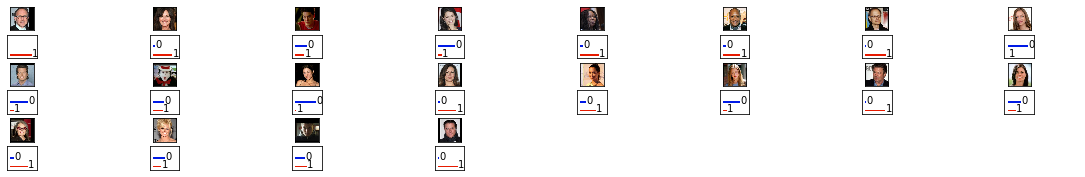

In [8]:
# doing 5th epoch now
loss_record = []
train_net(loss_record, train_num_epochs = 0)

In [6]:
def print_loss(loss_record):
    N = len(loss_record)
    plt.plot(range(N), loss_record, 'ro')
    plt.axis([0, N-1, 0, 1])
    plt.show()

In [7]:
import pickle
loss_record = pickle.load(open('loss_record.txt', 'rb'))

In [8]:
len(loss_record)/30

38.5

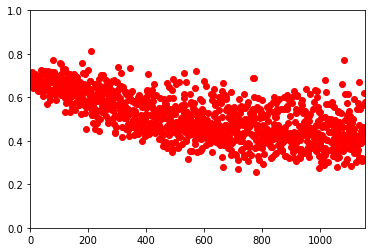

In [9]:
print_loss(loss_record)

## Questions 3), 4) and 5)

In [137]:
data_plt = pd.DataFrame(map(list,zip(*[range(len(loss_record)),loss_record])), columns=["Iteration", "Loss"])
data_plt

,Iteration,Loss
0,0,0.702165
1,1,0.673104
2,2,0.697387
3,3,0.685366
4,4,0.686738
...,...,...
1150,1150,0.434782
1151,1151,0.621582
1152,1152,0.461281
1153,1153,0.578761


In [138]:
def plot_data(data, window=5):
    data["Moving Average Loss"] = data["Loss"].rolling(window).mean()
    
    # Figure
    fig = plt.figure()
    ax = plt.axes()
    
    ax.scatter(data["Iteration"], data["Loss"], color="#FFE366", label="Loss")
    ax.plot(data["Iteration"], data["Moving Average Loss"], color="#3C3C3C", label="Loss Moving Average")
    
    ax.set_xlim([window, max(data["Iteration"]) - 10])
    ax.set_ylim([0, 1])
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    # ax.set_aspect(aspect=2)
    # ax.set_title("Loss")
    ax.set_xlabel('Iteration')
    # ax.set_ylabel('Loss')
    ax.legend()
    
    return data, fig

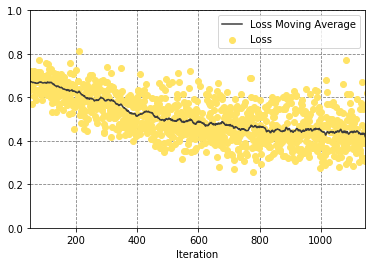

In [139]:
window=50

_, fig = plot_data(data_plt, window=window)
fig.savefig("loss" + ".svg", format="svg")

Remember here that each iteration on the graph above corresponds, in fact, to 30 batch iterations since only after every 30 batch steps we do a loss_record.append() inside the train_epoch() method.

In [141]:
batch_enum = enumerate(data.loader_test)
batch_idx, (testdata, testtargets) = next(batch_enum)
testdata = testdata.to(device)
testtargets = testtargets.to(device)
net = net.eval()
out = net(testdata)
pred = torch.argmax(net(testdata), dim=1)

In [143]:
# Printing the confusion matrix
confusion_matrix(testtargets.cpu(), pred.cpu())

array([[188,  52],
       [ 20, 240]])

In [144]:
y_actu = pd.Series(testtargets.cpu(), name='Actual')
y_pred = pd.Series(pred.cpu(), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

In [160]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

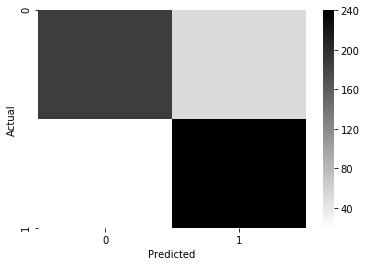

In [161]:
heatmap = sn.heatmap(df_confusion, annot=False, fmt=".0f", cmap=plt.cm.gray_r)

In [162]:
heatmap.get_figure().savefig("confusion" + ".svg", format="svg")

## Question 7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

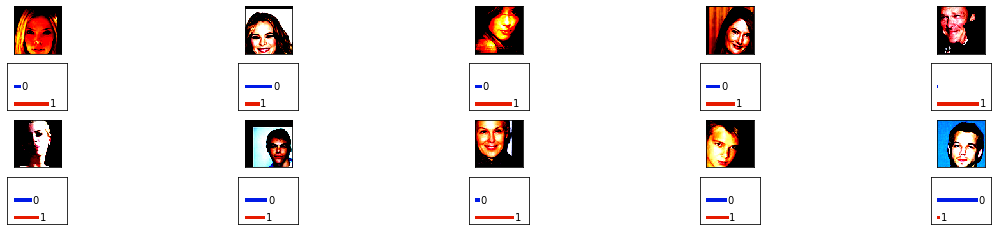

In [258]:
indices = np.random.choice(range(data.num_test_samples), 20)
plotdata(data, indices[10:20], net, original=False)

## Question 9)

In [11]:
batch_enum = enumerate(data.loader_test)
batch_idx, (testdata, testtargets) = next(batch_enum)
net = net.eval()
out = net(testdata)
pred = torch.argmax(net(testdata), dim=1)

net = net.train()
eq = pred == testtargets # comparing the network predctions with the real target labels

t = [] # true, the prediction matches what was expected
f = [] # false
for i, res in enumerate(eq):
    if res == True:
        t.append(i)
    else:
        f.append(i)

print(len(t)/len(testtargets)) # verifying if it is indeed around 80% (the current precision of our trained network)

0.826


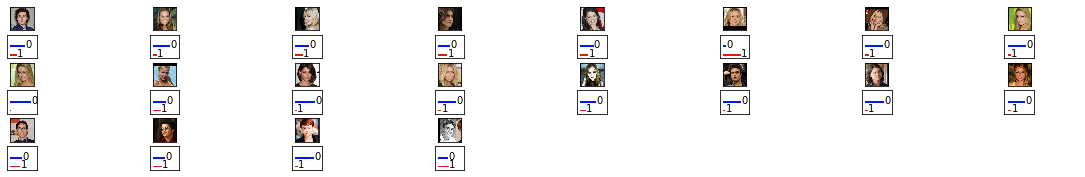

In [36]:
t = np.array(t)
f = np.array(f)
plotdata(data, f[0:20], net, original=True) # print some images for which our network gave wrong labels

## Question 12)

The code below was adapted from the code developed for one of the TPs of the RDFIA (Pattern Recognition for Image Analysis and Understanding) course - master IMA.

In [169]:
batch_enum = enumerate(data.loader_test)
batch_idx, (testdata, testtargets) = next(batch_enum)
print(testdata.shape)

torch.Size([500, 3, 75, 75])


In [170]:
# Calculating the mean and the standard deviation for every channel in the given dataset
dt = testdata.reshape(500, 3, -1) # [500, 3, 5625]
denominator = 500*75*75
mean0 = (dt[:, 0, :]).sum()/(denominator)
mean1 = (dt[:, 1, :]).sum()/(denominator)
mean2 = (dt[:, 2, :]).sum()/(denominator)

std0 = ((dt[:, 0, :] - mean0)**2).sum() / denominator
std1 = ((dt[:, 1, :] - mean1)**2).sum() / denominator
std2 = ((dt[:, 2, :] - mean2)**2).sum() / denominator

std0 = torch.sqrt(std0)
std1 = torch.sqrt(std1)
std2 = torch.sqrt(std2)

In [171]:
# Auxiliar functions:

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

# The two values below must be updated for the values of the dataset we have in hands
MEAN = np.array([mean2.item(), mean1.item(), mean0.item()], dtype=np.float32) #[0.485, 0.456, 0.406]
STD = np.array([std2.item(), std1.item(), std0.item()], dtype=np.float32) #[0.229, 0.224, 0.225]
class_names = ['Young', 'Old']

def blur_image(X_np, sigma=1):
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    return torch.tensor(X_np)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / STD).tolist()),
        T.Normalize(mean=(-MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def preprocess(img, size=75):
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=MEAN.tolist(), std=STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [218]:
def create_class_visualization(target_y, model, dtype, init_img=None, l2_reg=1e-3, learning_rate=5,
                               num_iterations=200, blur_every=10, max_jitter=16, show_every=25):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - init_img: Initial image to use (if None, will be random)
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)

    # Randomly initialize the image as a PyTorch Tensor:
    if init_img is None:
        img = torch.randn(1, 3, 75, 75).mul_(1.0).type(dtype)
    else:
        img = init_img.clone().mul_(1.0).type(dtype)
    img.requires_grad = True
    
    # For initial image:
    plt.imshow(deprocess(img.clone().cpu()))
    class_name = class_names[target_y]
    plt.title('%s\nIteration %d / %d' % (class_name, 0, num_iterations))
    plt.gcf().set_size_inches(4, 4)
    plt.axis('off')
    
    y_tilde = model(img)
    y_hat = torch.nn.Softmax(dim=1)(y_tilde) # can be understood as the probabilities for each class
    print('P(class young):', y_hat[0, 0].item(), 
        '\nP(class old):', y_hat[0, 1].item())
    
    plt.show()
    
    # Starting the iterations:
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        y_tilde = model(img)
        y_hat = torch.nn.Softmax(dim=1)(y_tilde) # can be understood as the probabilities for each class
        
        loss = y_tilde[0, target_y] - l2_reg * torch.norm(img)
        img.retain_grad()
        loss.backward()
        
        img = img + learning_rate * img.grad
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-MEAN[c] / STD[c])
            hi = float((1.0 - MEAN[c]) / STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            img.data = blur_image(img.data.cpu().numpy(), sigma=0.6)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            # Print the confidence about that class too, probabilities here
            print('P(class young):', y_hat[0, 0].item(), 
                  '\nP(class old):', y_hat[0, 1].item()) # print the confidence about that class too, probabilities here
            
            # print('y_tilde: ', y_tilde)
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
            

    return deprocess(img.cpu())

P(class young): 0.15069441497325897 
P(class old): 0.8493055701255798


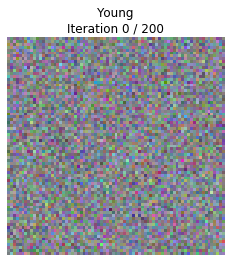

P(class young): 0.15112528204917908 
P(class old): 0.8488747477531433


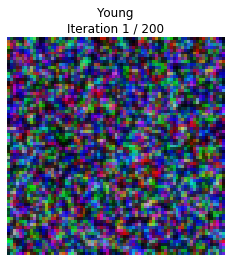

P(class young): 0.9951747059822083 
P(class old): 0.004825287032872438


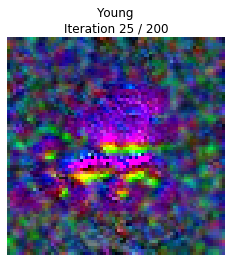

P(class young): 0.9997026324272156 
P(class old): 0.00029734635609202087


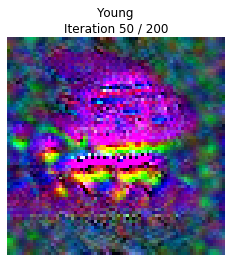

P(class young): 0.9999216794967651 
P(class old): 7.832622213754803e-05


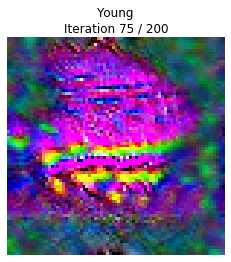

P(class young): 0.9999980926513672 
P(class old): 1.8585765246825758e-06


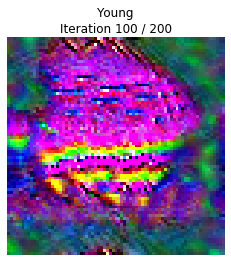

P(class young): 0.999994158744812 
P(class old): 5.808153673569905e-06


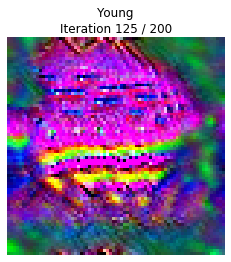

P(class young): 0.9999992847442627 
P(class old): 7.089608402566228e-07


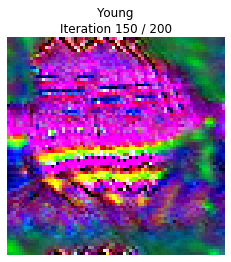

P(class young): 0.9999998807907104 
P(class old): 6.670477148418286e-08


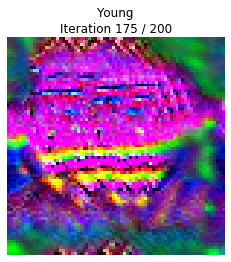

P(class young): 1.0 
P(class old): 6.88385881630893e-09


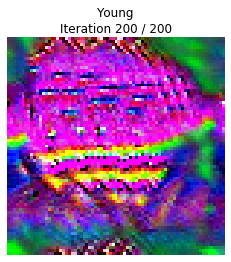

In [253]:
dtype = torch.FloatTensor

net_12 = net
net_12.type(dtype)

# generating an image maximizing a chosen class having started from noise
target_y = 0
out = create_class_visualization(target_y, net_12, dtype, show_every=25, 
                                 num_iterations=200)

P(class young): 0.20235349237918854 
P(class old): 0.7976465821266174


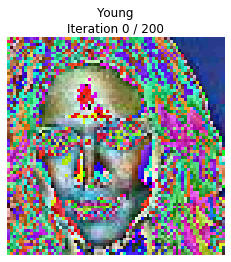

P(class young): 0.22389326989650726 
P(class old): 0.7761066555976868


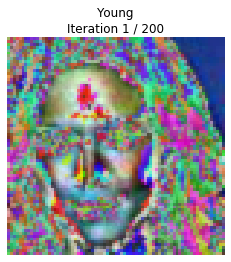

P(class young): 0.998863935470581 
P(class old): 0.0011361322831362486


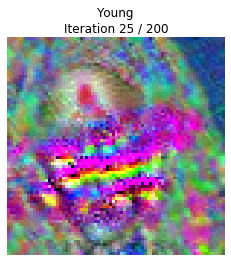

P(class young): 0.9999383687973022 
P(class old): 6.167047831695527e-05


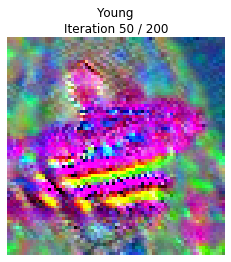

P(class young): 0.9999924898147583 
P(class old): 7.481197826564312e-06


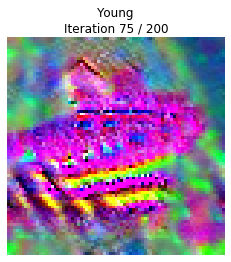

P(class young): 0.9999995231628418 
P(class old): 4.861468596573104e-07


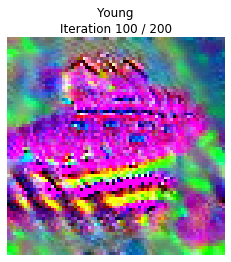

P(class young): 0.9999980926513672 
P(class old): 1.9162687294738134e-06


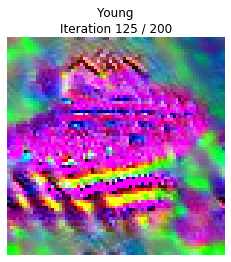

P(class young): 0.9999957084655762 
P(class old): 4.259627985447878e-06


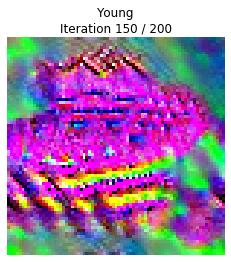

P(class young): 0.9999991655349731 
P(class old): 8.342699970853573e-07


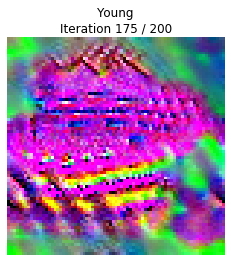

P(class young): 0.9999980926513672 
P(class old): 1.9010498135685339e-06


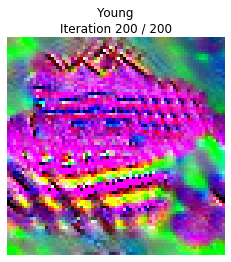

In [251]:
# Maximizing a chosen class starting from a given image
img_ind = 12

target_y = testtargets[img_ind]
pil_img = T.ToPILImage()(testdata[img_ind]).convert("RGB")
X_tensor = torch.Tensor(preprocess(pil_img))
out = create_class_visualization(target_y, net_12, dtype, init_img=X_tensor, show_every=25, num_iterations=200)